## Import packages

In [1]:
from numpy import *
import numpy as np
import pandas as pd
from math import log
import operator
import treePlotter

/Users/tracy/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Compute Entropy

In [2]:
def calcShannonEnt(dataSet):
    numEntries = len(dataSet)
    labelCounts = {}
    for featVec in dataSet:
        currentLabel = featVec[-1]
        if currentLabel not in labelCounts.keys():
            labelCounts[currentLabel] = 0
        labelCounts[currentLabel] += 1
    shannonEnt = 0.0
    for key in labelCounts:
        prob = float(labelCounts[key]) / numEntries
        shannonEnt -= prob * log(prob, 2)
    return shannonEnt

## Split dataset

In [3]:
#Split discrete dataset
def splitDataSet(dataSet, axis, value):
    retDataSet = []
    for featVec in dataSet:
        if featVec[axis] == value:
            reducedFeatVec = featVec[:axis]
            reducedFeatVec.extend(featVec[axis+1:])
            retDataSet.append(reducedFeatVec)
    return retDataSet

#Split continuous dataset
def splitContinuousDataSet(dataSet, axis, value, direction):
    retDataSet = []
    for featVec in dataSet:
        if direction == 0:
            if featVec[axis] > value:
                reducedFeatVec = featVec[:axis]
                reducedFeatVec.extend(featVec[axis+1:])
                retDataSet.append(reducedFeatVec)
        else:
            if featVec[axis] <= value:
                reducedFeatVec = featVec[:axis]
                reducedFeatVec.extend(featVec[axis+1:])
                retDataSet.append(reducedFeatVec)
    return retDataSet

## Choose Best Feature

In [17]:
def chooseBestFeatureToSplit(dataSet, labels):
    numFeatures = len(dataSet[0]) - 1
    baseEntropy = calcShannonEnt(dataSet)
    bestInfoGain = 0.0
    bestFeature = -1
    bestSplitDict = {}
    for i in range(numFeatures):
        featList = [example[i] for example in dataSet]
        # For continuous feature
        if type(featList[0]).__name__ == 'float' or type(featList[0]).__name__ == 'int':
            sortFeatList = sorted(featList)
            splitList = []
            for j in range(len(sortFeatList) - 1):
                splitList.append((sortFeatList[j] + sortFeatList[j + 1])/2.0)
                
            bestSplitEntropy = 10000
            slen = len(splitList)
            for j in range(slen):
                value = splitList[j]
                newEntropy = 0.0
                subDataSet0 = splitContinuousDataSet(dataSet, i, value, 0)
                subDataSet1 = splitContinuousDataSet(dataSet, i, value, 1)
                prob0 = len(subDataSet0) / float(len(dataSet))
                newEntropy += prob0 * calcShannonEnt(subDataSet0)
                prob1 = len(subDataSet1) / float(len(dataSet))
                newEntropy += prob1 * calcShannonEnt(subDataSet1)
                if newEntropy < bestSplitEntropy:
                    bestSplitEntropy = newEntropy
                    bestSplit = j
            bestSplitDict[labels[i]] = splitList[bestSplit]
            infoGain = baseEntropy - bestSplitEntropy
        else:
            uniqueVals = set(featList)
            newEntropy = 0.0
            for value in uniqueVals:
                subDataSet = splitDataSet(dataSet, i, value)
                prob = len(subDataSet) / float(len(dataSet))
                newEntropy += prob * calcShannonEnt(subDataSet)
            infoGain = baseEntropy - newEntropy
        if infoGain > bestInfoGain:
            bestInfoGain = infoGain
            bestFeature = i
            
    if type(dataSet[0][bestFeature]).__name__ == 'float' or type(dataSet[0][bestFeature]).__name__ == 'int':
        bestSplitValue = bestSplitDict[labels[bestFeature]]
        labels[bestFeature] = labels[bestFeature] + '<=' + str(bestSplitValue)
        for i in range(shape(dataSet)[0]):
            if dataSet[i][bestFeature] <= bestSplitValue:
                dataSet[i][bestFeature] = 1
            else:
                dataSet[i][bestFeature] = 0
    return bestFeature

def majorityCnt(classList):
    classCount = {}
    for vote in classList:
        if vote not in classCount.keys():
            classCount[vote] = 0
        classCount[vote] += 1
    return max(classCount);

## Construct Tree

In [19]:
def createTree(dataSet, labels, data_full, labels_full):
    classList = [example[-1] for example in dataSet]
    if classList.count(classList[0]) == len(classList):
        return classList[0]
    if len(dataSet[0]) == 1:
        return majorityCnt(classList)
    bestFeat = chooseBestFeatureToSplit(dataSet, labels)
    bestFeatLabel = labels[bestFeat]
    myTree = {bestFeatLabel:{}}
    featValues = [example[bestFeat] for example in dataSet]
    uniqueValues = set(featValues)
    if type(dataSet[0][bestFeat]).__name__ == 'str':
        currentLabel = labels_full.index(labels[bestFeat])
        featValuesFull = [example[currentLabel] for example in data_full]
        uniqueValuesFull = set(featValuesFull)
    del(labels[bestFeat])
    
    for value in uniqueValues:
        subLabels = labels[:]
        if type(dataSet[0][bestFeat]).__name__ == 'str':
            uniqueValuesFull.remove(value)
        myTree[bestFeatLabel][value] = createTree(splitDataSet(dataSet, bestFeat, value), subLabels, data_full, labels_full)
    if type(dataSet[0][bestFeat]).__name__ == 'str':
        for value in uniqueValuesFull:
            myTree[bestFeatLabel][value] = majorityCnt(classList)
    return myTree

## Train a decision_tree with dataSet

In [24]:
df = pd.read_csv('watermelon.csv')
data = df.values[:, 1:].tolist()
data_full = data[:]
labels = df.columns.values[1:-1].tolist()
labels_full = labels[:]

In [20]:
myTree = createTree(data,labels,data_full, labels_full)
>>>myTree

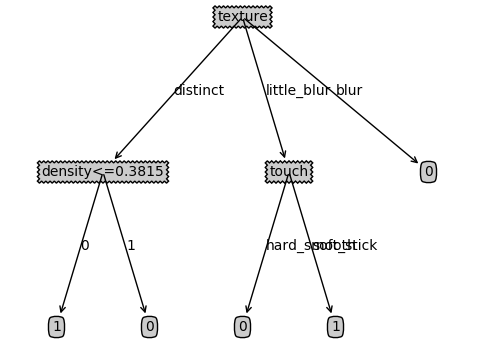

In [23]:
treePlotter.createPlot(myTree)